## Connect the gdrive and change working directory to `/content/gdrive/MyDrive/Colab_Notebooks/lrcn/`

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Colab_Notebooks/lrcn/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab_Notebooks/lrcn


## Load the required packages

In [ ]:
from keras import Sequential, regularizers, Model, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization, concatenate, add
from tensorflow.keras.optimizers import Adam
from keras.layers import SpatialDropout1D, LSTM, Dense, Dropout, MaxPooling1D, Conv1D, GRU, TimeDistributed, Flatten
import numpy as np
import pandas as pd
import random
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
import keras.backend as K
# from models import Bayesian_optimizer
from evaluations import plot, ROC_PR
from tensorflow.keras.layers import RepeatVector, Concatenate, Add

## Helper functions to load and prepare the data

In [ ]:
def masked_loss_function(y_true, y_pred):
    '''
    Custom loss function
    '''
    mask = K.cast(K.not_equal(y_true, -1), K.floatx())
    return K.binary_crossentropy(y_true * mask, y_pred * mask)


def masked_accuracy(y_true, y_pred):
    '''
    Custom accuracy function.
    '''
    dtype = K.floatx()
    total = K.sum(K.cast(K.not_equal(y_true, -1), dtype))
    correct = K.sum(K.cast(K.equal(y_true, K.round(y_pred)), dtype))
    return correct / total


def prepare_data(features, label, lrcn):
    '''
    This function prepare the data for LRCN and WnD depending on the argment passed.
    '''
    # TODO
    FrameSize = 200

    y = []
    temp_label = label
    for i in range(0, len(temp_label)):
        # print(i)
        temp_label[i] = temp_label[i].values.tolist()

    for j in range(0, len(temp_label[0])):
        tmp = []
        for i in range(0, len(temp_label)):
            if temp_label[i][j][0] != 0.0 and temp_label[i][j][0] != 1.0:
                tmp.extend([-1])
            else:
                tmp.extend(temp_label[i][j])
        y.append(tmp)


    if lrcn==True:
        X = features.values.tolist()
        for i in range(0, len(X)):
            if len(X[i]) < ((len(X[i]) // FrameSize + 1) * FrameSize):
                for j in range(0, (((len(X[i]) // FrameSize + 1) * FrameSize) - len(X[i]))):
                    X[i].append(0)
            X[i] = np.reshape(X[i], (FrameSize, len(X[i]) // FrameSize))
        X = np.array(X)
        y = np.array(y)
        return X, y, FrameSize

    else:
        features = np.array(features)
        y = np.array(y)
        return features, y, FrameSize


# def prepare_data_wnd(features, label):
#     FrameSize = 200

#     y = []
#     for i in range(0, len(label)):
#         label[i] = label[i].values.tolist()

#     for j in range(0, len(label[0])):
#         tmp = []
#         for i in range(0, len(label)):
#             if label[i][j][0] != 0.0 and label[i][j][0] != 1.0:
#                 tmp.extend([-1])
#             else:
#                 tmp.extend(label[i][j])
#         y.append(tmp)

#     y = np.array(y)
#     features = np.array(features)
#     return features, y, FrameSize



def load_data_gene_dataset(path):
    '''
    This function load the gene burden-based data.
    '''
    dt = pd.read_csv(path + 'gene_data.csv', header=None)
    dt.set_index(dt.columns[0], inplace=True, drop=True)
    return dt



def load_data(lst, path):
    '''
    This function loads the SNP data files 1-38.
    '''

    lst = sorted(np.unique(lst))
    dtypes = dict(zip(list(range(0, 20000)), [np.float32] * 20000))

    if lst[0] == 1:
        dt = pd.read_csv(path + 'SNP_data/' + 'file-' + str(lst[0]) + '.csv', header=None)
        dt.set_index(dt.columns[0], inplace=True, drop=True)
        dt = dt.astype(np.int8)
    else:
        dt = pd.read_csv(path + 'SNP_data/' + 'file-' + str(lst[0]) + '.csv', header=None, dtype=dtypes)
        isolates = pd.read_csv(path + 'iso_list.csv', header=None)[0].values.tolist()
        dt.index = isolates

    for i in lst[1:]:
        tmp = pd.read_csv(path + 'SNP_data/' + 'file-' + str(i) + '.csv', header=None, dtype=dtypes)
        tmp.index = dt.index
        dt = pd.concat([dt, tmp], axis='columns', ignore_index=True)
        print("read {}th file".format(i))

    dt.columns = list(range(0, len(dt.columns)))

    print(dt.shape)
    dt = dt.loc[:, dt.sum() >= 0]
    print("After dropping")
    print(dt.shape)

    return (dt)


def load_label(path):
    '''
    This function load the labels for SNP data.
    '''
    dt = pd.read_csv(path + 'AllLabels' + '.csv')
    dt.set_index(dt.columns[0], inplace=True, drop=True)
    return dt


def process(num_of_files, nrow=0, gene=False, limited=False, gene_dataset=False, shuffle_index=False, random_data=False,
            shuffle_operon=False, shuffle_operon_locally=False, shuffle_operon_group=False, index_file=0):
    
    '''
    Just a helper function.
    '''
    
    if gene:
        df_train = load_data.load_data_gene(list(range(0, num_of_files)), 'Data/')

    # if above condition is not satisfied 
    elif gene_dataset:
        df_train = load_data_gene_dataset('Data/')
    # elif shuffle_index:
    #     df_train = load_data_shuffle_dataset('Data/', index_file)
    # elif random_data:
    #     df_train = load_data_random_dataset('Data/')
    # elif shuffle_operon:
    #     df_train = load_data_operon_dataset('Data/')
    # elif shuffle_operon_locally:
    #     df_train = load_data_operon_locally_dataset('Data/')
    # elif shuffle_operon_group:
    #     df_train = load_data_operon_group_dataset('Data/')
    else:
        df_train = load_data(list(range(1, num_of_files)), 'Data/')

    # df_train = df_train[df_train.columns[df_train.sum() > 5]]

    df_label = load_label('Data/') # read alllabels.csv file 

    if limited:
        df_label = df_label.drop(['ciprofloxacin'], axis=1)
        df_label = df_label.drop(['capreomycin'], axis=1)
        df_label = df_label.drop(['amikacin'], axis=1)
        df_label = df_label.drop(['ethionamide'], axis=1)
        df_label = df_label.drop(['moxifloxacin'], axis=1)


    print('label set: {0}'.format(df_label.shape))

    df_train = df_train.merge(df_label, left_index=True, right_index=True)

    print('train set: {0}'.format(df_train.shape))
    labels = []

    labels_list = []

    dfStreptomycin = df_train[['streptomycin']]
    labels.append(dfStreptomycin)
    labels_list.append(df_train['streptomycin'])

    dfRifampicin = df_train[['rifampicin']]
    labels.append(dfRifampicin)
    labels_list.append(df_train['rifampicin'])

    dfPyrazinamide = df_train[['pyrazinamide']]
    labels.append(dfPyrazinamide)
    labels_list.append(df_train['pyrazinamide'])


    dfOfloxacin = df_train[['ofloxacin']]
    labels.append(dfOfloxacin)
    labels_list.append(df_train['ofloxacin'])


    if not limited:
        dfMoxifloxacin = df_train[['moxifloxacin']]
        labels.append(dfMoxifloxacin)
        labels_list.append(df_train['moxifloxacin'])

    dfKanamycin = df_train[['kanamycin']]
    labels.append(dfKanamycin)
    labels_list.append(df_train['kanamycin'])


    dfIsoniazid = df_train[['isoniazid']]
    labels.append(dfIsoniazid)
    labels_list.append(df_train['isoniazid'])


    if not limited:
        dfEthionamide = df_train[['ethionamide']]
        labels.append(dfEthionamide)
        labels_list.append(df_train['ethionamide'])

    dfEthambutol = df_train[['ethambutol']]
    labels.append(dfEthambutol)
    labels_list.append(df_train['ethambutol'])


    if not limited:
        dfCiprofloxacin = df_train[['ciprofloxacin']]
        labels.append(dfCiprofloxacin)
        labels_list.append(df_train['ciprofloxacin'])

        dfCapreomycin = df_train[['capreomycin']]
        labels.append(dfCapreomycin)
        labels_list.append(df_train['capreomycin'])

        dfAmikacin = df_train[['amikacin']]
        labels.append(dfAmikacin)
        labels_list.append(df_train['amikacin'])

    df_train = df_train.drop(['streptomycin'], axis=1)
    df_train = df_train.drop(['rifampicin'], axis=1)
    df_train = df_train.drop(['pyrazinamide'], axis=1)
    df_train = df_train.drop(['ofloxacin'], axis=1)
    if not limited:
        df_train = df_train.drop(['moxifloxacin'], axis=1)
    df_train = df_train.drop(['kanamycin'], axis=1)
    df_train = df_train.drop(['isoniazid'], axis=1)
    if not limited:
        df_train = df_train.drop(['ethionamide'], axis=1)
    df_train = df_train.drop(['ethambutol'], axis=1)
    if not limited:
        df_train = df_train.drop(['ciprofloxacin'], axis=1)
        df_train = df_train.drop(['capreomycin'], axis=1)
        df_train = df_train.drop(['amikacin'], axis=1)
    # print(dfStreptomycin.head(10))
    if gene:
        df_train = one_hot_gene(df_train)


    # common_elements(labels_list)

    return df_train, labels


def one_hot_gene(df_train):
    # df_train = df_train.iloc[0:50]
    tmp = df_train.values.tolist()
    for i in range(0, len(tmp)):
        if i % 100 == 0:
            print(i)
        for j in range(0, len(tmp[0])):
            one = []
            for k in range(0, len(tmp[i][j])):
                if tmp[i][j][k] == 'A':
                    one.append(True)
                    one.append(False)
                    one.append(False)
                    one.append(False)
                elif tmp[i][j][k] == 'C':
                    one.append(False)
                    one.append(True)
                    one.append(False)
                    one.append(False)
                elif tmp[i][j][k] == 'T':
                    one.append(False)
                    one.append(False)
                    one.append(True)
                    one.append(False)
                elif tmp[i][j][k] == 'G':
                    one.append(False)
                    one.append(False)
                    one.append(False)
                    one.append(True)
                else:
                    print("Error!")
            tmp[i][j] = one
    # print(pd.DataFrame(tmp))
    return pd.DataFrame(tmp)

In [ ]:
def model_CNN_LSTM(FrameSize, X, X_train, X_test, y_train, y_test):
    print(X.shape)
    print(FrameSize)

    input = Input(shape=(FrameSize, X[0].shape[1]))
    conv1d_layer_1 = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(input)
    maxpool_layer_1 = MaxPooling1D(pool_size=3, padding='same')(conv1d_layer_1)
    lstm_layer_1 = LSTM(518, return_sequences=False, recurrent_dropout=0.3)(maxpool_layer_1)
    dropout_layer_1 = Dropout(0.1)(lstm_layer_1)
    dense_layer_1 = Dense(64)(dropout_layer_1)
    dropout_layer_2 = Dropout(0.1)(dense_layer_1)
    preds = Dense(12, activation='sigmoid')(dropout_layer_2)

    model = Model(inputs=input, outputs=preds)





    # model = Sequential()
    # model.add(Dropout(0.1))
    # model.add(Conv1D(filters=8, kernel_size=3, activation='relu', padding='same', input_shape=input_shape))
    # model.add(MaxPooling1D(pool_size=3, padding='same'))

    # model.add(LSTM(518, return_sequences=False, recurrent_dropout=0.3))
    # model.add(Dropout(0.1))

    # model.add(Dense(64))
    # model.add(Dropout(0.1))

    # model.add(Dense(12, activation='sigmoid'))

    model.compile(
        loss=masked_loss_function,
        optimizer='Adam',
        metrics=[masked_accuracy]
    )

    plot_model(model, to_file='Data/plot_/model_CNN_LSTM.png', show_shapes=True, show_layer_names=True)

    return model

In [ ]:
def model_CNN_LSTM_time(FrameSize, X, X_train, X_test, y_train, y_test):
    print(X.shape)
    print(X_train.shape)
    print(X_test.shape)
    print(FrameSize)
    print(y_train.shape)
    print(y_test.shape)
    print("X_train.shape {}".format(X_train.shape))
    print("FrameSize {}".format(FrameSize))
    input=(FrameSize, X[0].shape[1], 1)
    # input_shape= K.cast(input, dtype='float32')

    # X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    # X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    # y_train = y_train.reshape(7060, 12, 1)
    # y_test = y_test.reshape(785, 12, 1)

    inputs = Input(shape=input)
    conv_1d_layer_1 = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')
    x1 = TimeDistributed(conv_1d_layer_1)(inputs)
    max_pool_1 = MaxPooling1D(pool_size=3, padding='same')
    x2 = TimeDistributed(max_pool_1)(x1)
    conv_1d_layer_2 = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')
    x3 = TimeDistributed(conv_1d_layer_2)(x2)
    max_pool_2 = MaxPooling1D(pool_size=3, padding='same')
    x4 = TimeDistributed(max_pool_2)(x3)
    flatten_1 = Flatten()
    x5 = TimeDistributed(flatten_1)(x4)
    lstm_1 = LSTM(518, return_sequences=False, recurrent_dropout=0.3)(x5)
    dropout_1 = Dropout(0.1)(lstm_1)
    dense_1 = Dense(64)(dropout_1)
    dropout_2 = Dropout(0.1)(dense_1)
    preds = Dense(12, activation='sigmoid')(dropout_2)

    model = Model(inputs=inputs, outputs=preds)




    # model = Sequential()
    # model.add(Dropout(0.1))
    # model.add(TimeDistributed(Conv1D(filters=8, kernel_size=3, activation='relu', padding='same', input_shape=inputs)))
    # model.add(TimeDistributed(MaxPooling1D(pool_size=3, padding='same')))
    # model.add(TimeDistributed(Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')))
    # model.add(TimeDistributed(MaxPooling1D(pool_size=3, padding='same')))
    # model.add(TimeDistributed(Flatten()))

    # model.add(LSTM(518, return_sequences=False, recurrent_dropout=0.3))
    # model.add(Dropout(0.1))

    # model.add(Dense(64))
    # model.add(Dropout(0.1))

    # model.add(Dense(12, activation='sigmoid'))

    model.compile(
        loss=masked_loss_function,
        optimizer='Adam',
        metrics=[masked_accuracy]
    )

    plot_model(model, to_file='Data/plot_/model_CNN_LSTM_time.png', show_shapes=True, show_layer_names=True)

    return model

In [ ]:
def create_plots(model, X2_test, y2_test, name):
    """
    This function call the ROC and ROC_Score functions from ROC_PR.py file to
    generate plots for Accuracy, loss, ROC for each and all genes. 
    """

    score = ROC_PR.ROC(model, X2_test, y2_test, name, True)
    return score, ROC_PR.ROC_Score(model, X2_train, y2_train, limited=False)

## Load the data and perform pre-processing steps. Split the data into train and test set. 

In [ ]:
df_train, labels = process(3, gene_dataset=True)
X2, y2, FrameSize = prepare_data(df_train, labels, lrcn=True)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=1, shuffle=True)

label set: (22376, 12)
train set: (7845, 3979)


## Define params 

In [ ]:
# params 
epochs = 50
batch_size = 128
earlyStopping = EarlyStopping(monitor='val_masked_accuracy', mode='max', min_delta=0.1, verbose=1, patience=50)

## Create model instance and train the model.

In [ ]:
model = model_CNN_LSTM(FrameSize, X2, X2_train, X2_test, y2_train, y2_test)
# model = model_CNN_LSTM_time(FrameSize, X2, X2_train, X2_test, y2_train, y2_test)

history = model.fit(
                X2_train,
                y2_train,
                epochs=epochs,
                batch_size=batch_size,
                verbose=2,
                steps_per_epoch=len([X2_train][0])//batch_size,
                validation_data=(X2_test, y2_test),
                callbacks=[earlyStopping, ModelCheckpoint('Data/lrcn_wnd_checkpoint/lrcn.h5', monitor='val_masked_accuracy', mode='max', save_best_only=True)]
)

(7845, 200, 20)
200
Epoch 1/50
49/49 - 135s - loss: 0.2861 - masked_accuracy: 0.6588 - val_loss: 0.2774 - val_masked_accuracy: 0.6826 - 135s/epoch - 3s/step
Epoch 2/50
49/49 - 129s - loss: 0.2776 - masked_accuracy: 0.6719 - val_loss: 0.2726 - val_masked_accuracy: 0.6961 - 129s/epoch - 3s/step
Epoch 3/50
49/49 - 132s - loss: 0.2685 - masked_accuracy: 0.7004 - val_loss: 0.2657 - val_masked_accuracy: 0.7002 - 132s/epoch - 3s/step
Epoch 4/50
49/49 - 132s - loss: 0.2642 - masked_accuracy: 0.7072 - val_loss: 0.2663 - val_masked_accuracy: 0.7017 - 132s/epoch - 3s/step
Epoch 5/50
49/49 - 131s - loss: 0.2579 - masked_accuracy: 0.7106 - val_loss: 0.2587 - val_masked_accuracy: 0.7044 - 131s/epoch - 3s/step
Epoch 6/50
49/49 - 131s - loss: 0.2613 - masked_accuracy: 0.7037 - val_loss: 0.2593 - val_masked_accuracy: 0.7155 - 131s/epoch - 3s/step
Epoch 7/50
49/49 - 131s - loss: 0.2543 - masked_accuracy: 0.7197 - val_loss: 0.2507 - val_masked_accuracy: 0.7307 - 131s/epoch - 3s/step
Epoch 8/50
49/49 - 13

## After getting the best model, generate the plots.

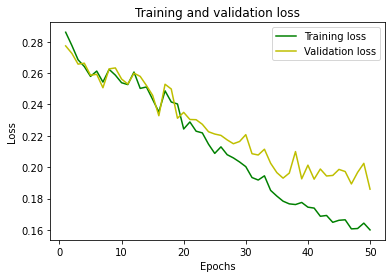

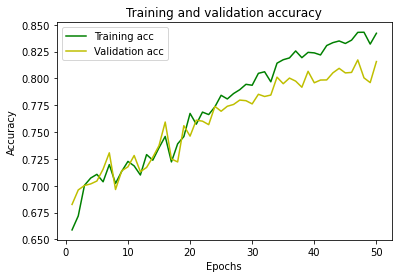

ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(0,2):
    plot.plot(history, ("LRCN" + "gene_10_" + str(i)))
    create_plots(model, X2_test, y2_test, name = ("LRCN" + "gene_10_" + str(i)))

In [ ]:
model = model_CNN_LSTM_time(FrameSize, X2, X2_train, X2_test, y2_train, y2_test)

history = model.fit(
                X2_train,
                y2_train,
                epochs=epochs,
                batch_size=batch_size,
                verbose=2,
                steps_per_epoch=len([X2_train][0])//batch_size,
                validation_data=(X2_test, y2_test),
                callbacks=[earlyStopping, ModelCheckpoint('Data/lrcn_wnd_checkpoint/lrcn.h5', monitor='val_masked_accuracy', mode='max', save_best_only=True)]
)

(7845, 200, 20)
(6276, 200, 20)
(1569, 200, 20)
200
(6276, 12)
(1569, 12)
X_train.shape (6276, 200, 20)
FrameSize 200
Epoch 1/50
49/49 - 413s - loss: 0.2855 - masked_accuracy: 0.6631 - val_loss: 0.2795 - val_masked_accuracy: 0.6863 - 413s/epoch - 8s/step
Epoch 2/50
49/49 - 398s - loss: 0.2985 - masked_accuracy: 0.6617 - val_loss: 0.2778 - val_masked_accuracy: 0.6816 - 398s/epoch - 8s/step
Epoch 3/50
49/49 - 398s - loss: 0.2754 - masked_accuracy: 0.6874 - val_loss: 0.2700 - val_masked_accuracy: 0.6929 - 398s/epoch - 8s/step
Epoch 4/50
49/49 - 398s - loss: 0.2731 - masked_accuracy: 0.6855 - val_loss: 0.2693 - val_masked_accuracy: 0.6959 - 398s/epoch - 8s/step
Epoch 5/50
49/49 - 401s - loss: 0.2683 - masked_accuracy: 0.7029 - val_loss: 0.2670 - val_masked_accuracy: 0.6977 - 401s/epoch - 8s/step
Epoch 6/50
49/49 - 400s - loss: 0.2656 - masked_accuracy: 0.7056 - val_loss: 0.2661 - val_masked_accuracy: 0.7001 - 400s/epoch - 8s/step
Epoch 7/50
49/49 - 397s - loss: 0.2615 - masked_accuracy: 0.

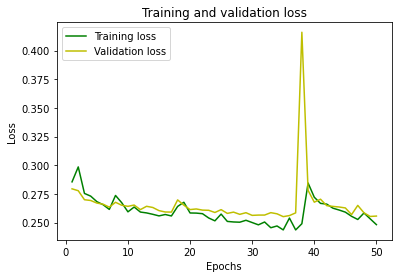

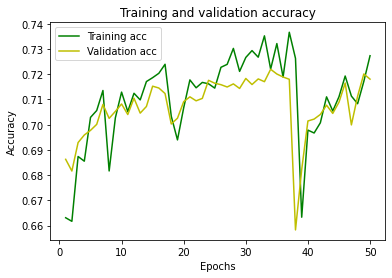

ValueError: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(0,2):
    plot.plot(history, ("LRCN" + "gene_10_" + str(i)))
    create_plots(model, X2_test, y2_test, name = ("LRCN" + "gene_10_" + str(i)))